In [1]:
# Imports and environment setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')


from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, auc


# Custom utils functions
from utils.visualization import show_train_val_confusion_matrix
from utils.visualization import visualize_training

In [2]:
df_train = pd.read_csv("../data/processed_train.csv")
df_test = pd.read_csv("../data/processed_test.csv")

# Separate our features (X) and target (y)
df_X = df_train.drop(["Sepsis"], axis=1)
df_y = df_train[["Sepsis"]]

# Splitting our training data into a train set and a validation set
train_X, val_X, train_y, val_y = train_test_split(
    df_X, df_y,
    shuffle=True,
    random_state=0,  # Ensure reproducible results
    test_size=0.2    # 80% Train - 20% Validation
)

print(f"train_X shape: {train_X.shape}")
print(f"train_y shape: {train_y.shape}")
print(f"val_X shape: {val_X.shape}")
print(f"val_y shape: {val_y.shape}")

train_X shape: (625, 8)
train_y shape: (625, 1)
val_X shape: (157, 8)
val_y shape: (157, 1)


In [3]:
cv = KFold(
    n_splits=4,     # Each fold is 20% of df_X
    shuffle=True,
    random_state=0  # Reproducible result
)

In [4]:
tree_params = {
    "max_depth": np.arange(2, 24, 2),
    "min_samples_split": np.arange(2, 10, 2),
}

base_clf_tree = DecisionTreeClassifier(
    criterion="gini",  # Good for balanced data (we have already up-sampled out data so it is now balanced)
    class_weight="balanced",
    random_state=0  # Reproducible result
)

tree_clf = GridSearchCV(
    base_clf_tree,
    tree_params,
    cv=cv, scoring=["f1", "roc_auc"], refit="f1",
    return_train_score=True,
    n_jobs=-1
)
tree_clf.fit(train_X, train_y.values.ravel())

GridSearchCV(cv=KFold(n_splits=4, random_state=0, shuffle=True),
             estimator=DecisionTreeClassifier(class_weight='balanced',
                                              random_state=0),
             n_jobs=-1,
             param_grid={'max_depth': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22]),
                         'min_samples_split': array([2, 4, 6, 8])},
             refit='f1', return_train_score=True, scoring=['f1', 'roc_auc'])

In [5]:
tree_clf.best_params_

{'max_depth': 8, 'min_samples_split': 2}

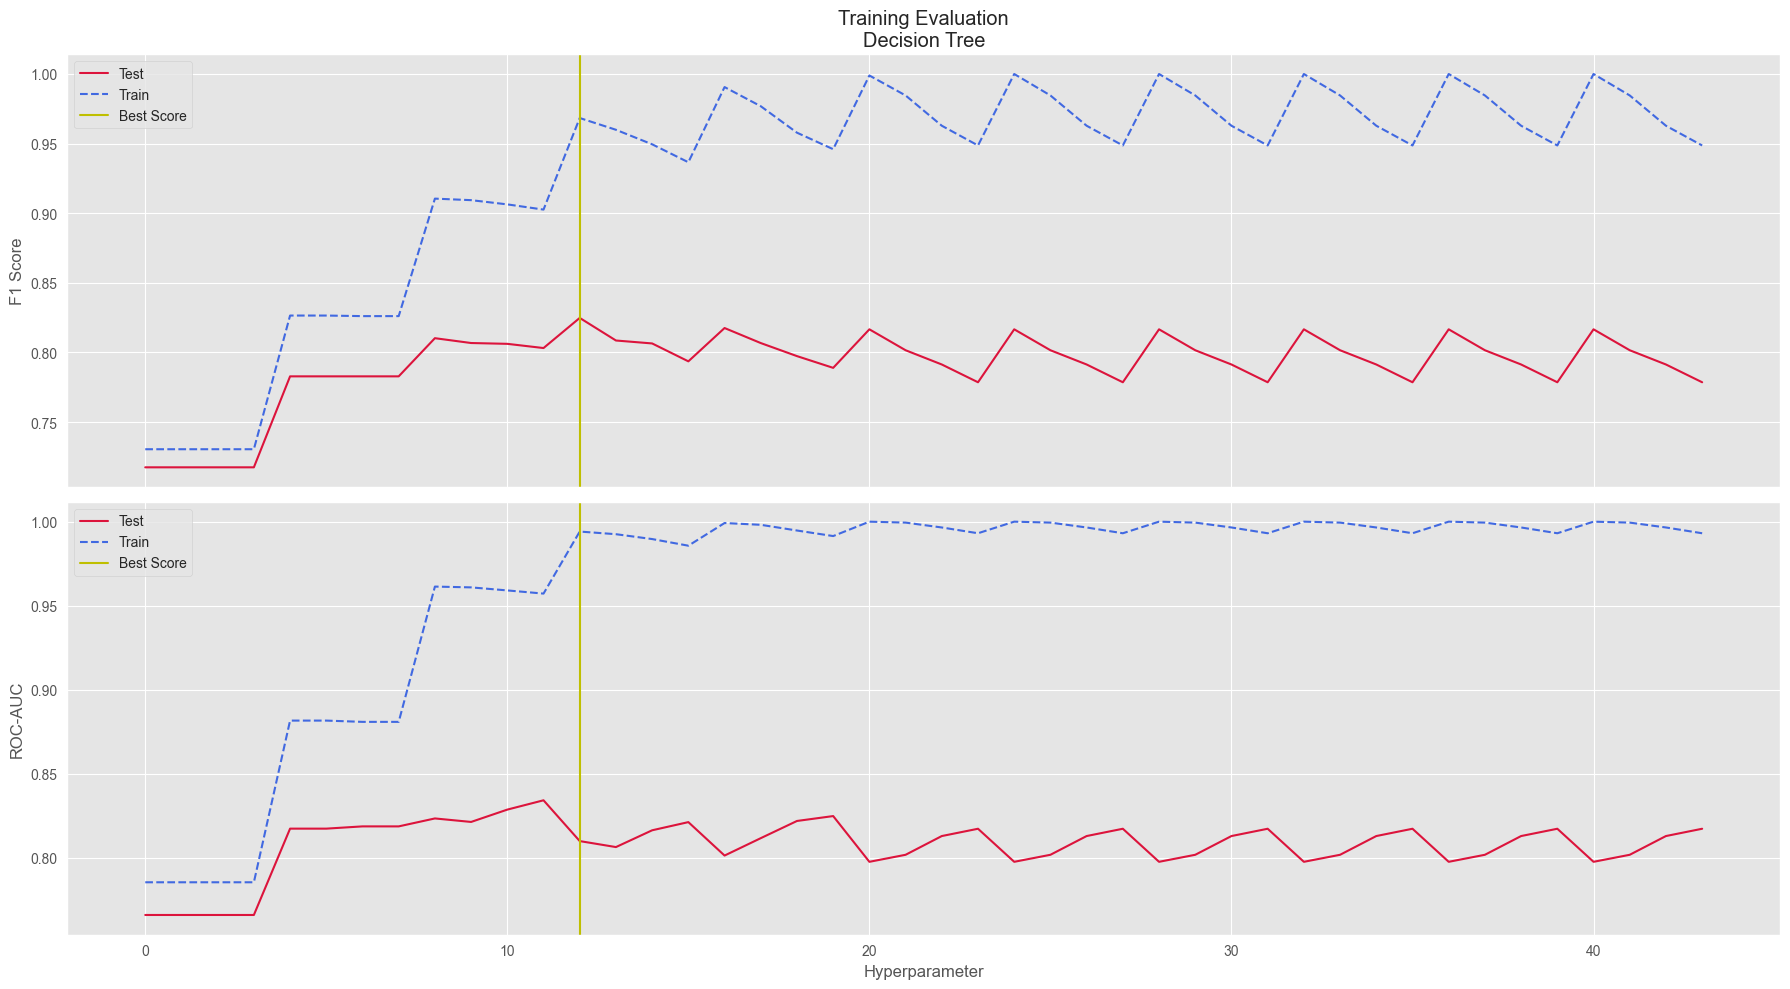

In [6]:
visualize_training(tree_clf, "Training Evaluation\nDecision Tree", "../images/Optimization_Tree_TrainValCompare.png")

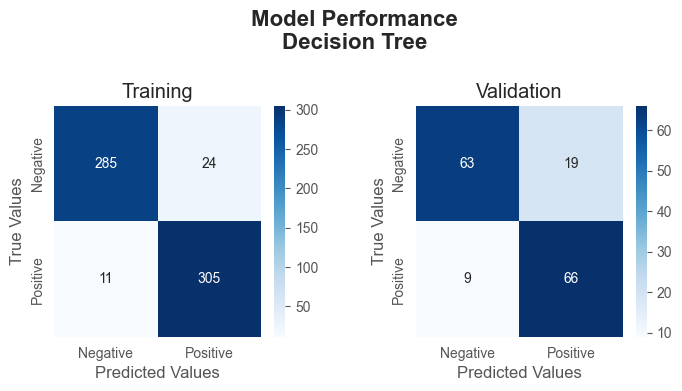

╔═══════════════════════════════════════════════════╗
║               TRAINING PERFORMANCE                ║
╚═══════════════════════════════════════════════════╝
              precision    recall  f1-score   support

         0.0       0.96      0.92      0.94       309
         1.0       0.93      0.97      0.95       316

    accuracy                           0.94       625
   macro avg       0.94      0.94      0.94       625
weighted avg       0.94      0.94      0.94       625

╔═══════════════════════════════════════════════════╗
║              VALIDATION PERFORMANCE               ║
╚═══════════════════════════════════════════════════╝
              precision    recall  f1-score   support

         0.0       0.88      0.77      0.82        82
         1.0       0.78      0.88      0.82        75

    accuracy                           0.82       157
   macro avg       0.83      0.82      0.82       157
weighted avg       0.83      0.82      0.82       157



In [7]:
train_pred_y = tree_clf.predict(train_X)
val_pred_y = tree_clf.predict(val_X)
show_train_val_confusion_matrix(train_y, train_pred_y, val_y, val_pred_y, "Model Performance\nDecision Tree", "../images/Optimization_Tree_CM.png")

In [8]:
bagged_trees_params = {
    "n_estimators": np.arange(5, 25, 5),
    "max_samples": np.arange(0.1, 1.0, 0.1),
}

base_clf_trees = BaggingClassifier(
    estimator=tree_clf,
    random_state=0, # Reproducible result
    n_jobs=-1
)

trees_clf = GridSearchCV(
    base_clf_trees,
    bagged_trees_params,
    cv=cv, scoring=["f1", "roc_auc"], refit="f1",
    return_train_score=True,
    n_jobs=-1
)
trees_clf.fit(train_X, train_y.values.ravel())

KeyboardInterrupt: 

In [ ]:
trees_clf.best_params_

In [ ]:
visualize_training(trees_clf, "Training Evaluation\nDecision Tree", "../images/Optimization_BaggedTrees_TrainValCompare.png")

In [ ]:
train_pred_y = trees_clf.predict(train_X)
val_pred_y = trees_clf.predict(val_X)
show_train_val_confusion_matrix(train_y, train_pred_y, val_y, val_pred_y, "Model Performance\nDecision Tree", "../images/Optimization_BaggedTrees_CM.png")